In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
df = pd.read_csv('data/Steel_industry_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   date                                  35040 non-null  object 
 1   Usage_kWh                             35040 non-null  float64
 2   Lagging_Current_Reactive.Power_kVarh  35040 non-null  float64
 3   Leading_Current_Reactive_Power_kVarh  35040 non-null  float64
 4   CO2(tCO2)                             35040 non-null  float64
 5   Lagging_Current_Power_Factor          35040 non-null  float64
 6   Leading_Current_Power_Factor          35040 non-null  float64
 7   NSM                                   35040 non-null  int64  
 8   WeekStatus                            35040 non-null  object 
 9   Day_of_week                           35040 non-null  object 
 10  Load_Type                             35040 non-null  object 
dtypes: float64(6), 

In [3]:
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y %H:%M')
df['month'] = df['date'].dt.month
# не используем год, т.к. он одинаковый
df['hour'] = df['date'].dt.hour
df['minute'] = df['date'].dt.minute
df = df.drop('date', axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 13 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Usage_kWh                             35040 non-null  float64
 1   Lagging_Current_Reactive.Power_kVarh  35040 non-null  float64
 2   Leading_Current_Reactive_Power_kVarh  35040 non-null  float64
 3   CO2(tCO2)                             35040 non-null  float64
 4   Lagging_Current_Power_Factor          35040 non-null  float64
 5   Leading_Current_Power_Factor          35040 non-null  float64
 6   NSM                                   35040 non-null  int64  
 7   WeekStatus                            35040 non-null  object 
 8   Day_of_week                           35040 non-null  object 
 9   Load_Type                             35040 non-null  object 
 10  month                                 35040 non-null  int64  
 11  hour           

In [4]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['WeekStatus'] = le.fit_transform(df['WeekStatus'])
df['Day_of_week'] = le.fit_transform(df['Day_of_week'])
df['Load_Type'] = le.fit_transform(df['Load_Type'])
df = df.astype(float)
df.head()

,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type,month,hour,minute
0,3.17,2.95,0.0,0.0,73.21,100.0,900.0,0.0,1.0,0.0,1.0,0.0,15.0
1,4.00,4.46,0.0,0.0,66.77,100.0,1800.0,0.0,1.0,0.0,1.0,0.0,30.0
2,3.24,3.28,0.0,0.0,70.28,100.0,2700.0,0.0,1.0,0.0,1.0,0.0,45.0
3,3.31,3.56,0.0,0.0,68.09,100.0,3600.0,0.0,1.0,0.0,1.0,1.0,0.0
4,3.82,4.50,0.0,0.0,64.72,100.0,4500.0,0.0,1.0,0.0,1.0,1.0,15.0


<AxesSubplot:>

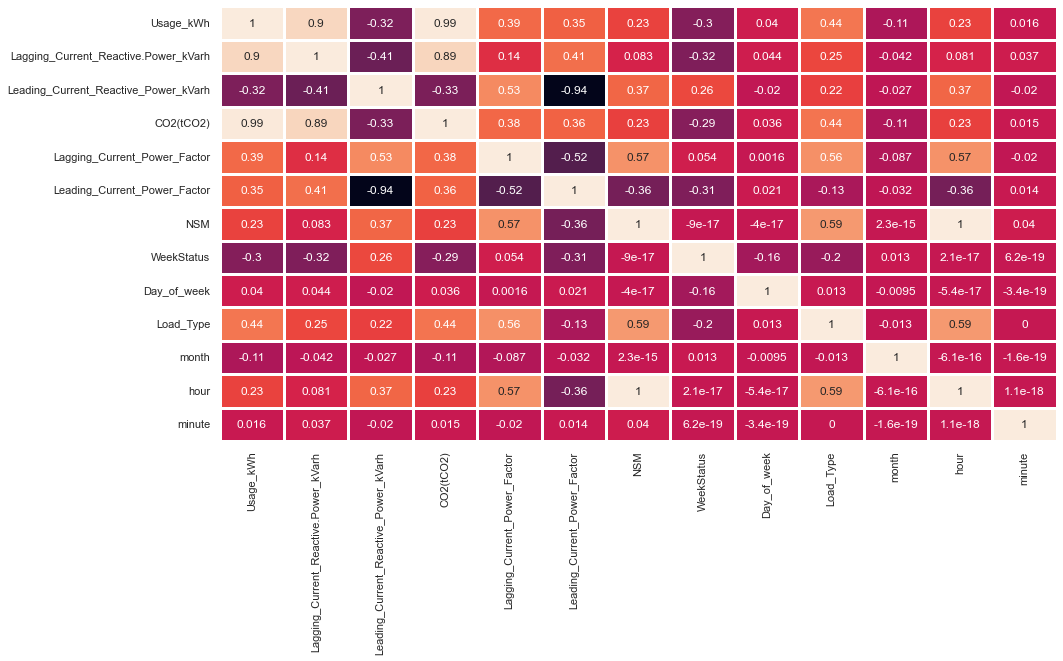

In [5]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(df.corr(), annot=True, linewidths=3, cbar=False)

In [6]:
# Разбиение данных на интервалы, т.к. для расчета энтропии необходимо, чтобы все значения были категориальными.
def split_data_into_intervals(data: pd.DataFrame):
    data = data.copy()
    for i in data.columns:
        n_intervals = int(np.ceil(np.log2(data[i].count()) + 1))
        data[i] = pd.cut(data[i], n_intervals)
    return data


def calc_entropy(data: pd.DataFrame, feature: str):
    entropy = 0
    capacity = data[feature].count()
    for i in data[feature].value_counts():
        p = i / capacity
        if p == 0:
            continue
        entropy += -p * np.log2(p)
    return entropy

# Вычисление sub-entropies для каждого значения признака
def calc_conditional_entropies(data: pd.DataFrame, feature: str, target: str):
    data_values = data[feature].value_counts().sort_index()
    entropies = []
    for i in range(len(data_values)):
        target_data = data[data[feature] == data_values.index[i]]
        if target_data[target].count() == 0:
            entropies.append([data_values.iloc[i], 0])
        else:
            entropies.append([data_values.iloc[i], calc_entropy(target_data, target)])
    return entropies

def calc_information_gain(data: pd.DataFrame, feature: str, target: str):
    entropy = calc_entropy(data, target)
    conditional_entropies = calc_conditional_entropies(data, feature, target)
    for i in range(len(conditional_entropies)):
        entropy -= conditional_entropies[i][0] * conditional_entropies[i][1] / data[feature].count()
    return entropy

def calc_intrinsic_information(data: pd.DataFrame, feature: str):
    ii = 0
    for i in range(len(data[feature].value_counts())):
        d = data[feature].value_counts().iloc[i] / data[feature].count()
        if d == 0:
            continue
        ii += -d * np.log2(d)
    return ii

def calc_information_gain_ratio(data: pd.DataFrame, feature: str, target: str):
    ig = calc_information_gain(data, feature, target)
    ii = calc_intrinsic_information(data, feature)
    if ii == 0:
        return 0
    return ig / ii

df_i = split_data_into_intervals(df)
feature_cols = df_i.columns.drop('Usage_kWh')
usage_gr = {}
for i in feature_cols:
    usage_gr[i] = calc_information_gain_ratio(df_i, i, 'Usage_kWh')

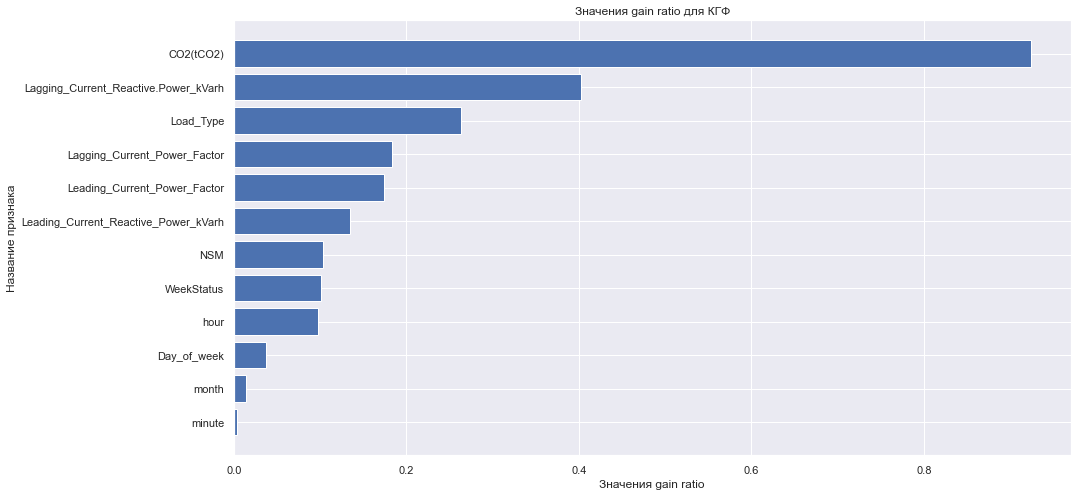

In [7]:
import matplotlib.pyplot as plt

names = list(usage_gr.keys())
values = list(usage_gr.values())

sorted_kgf_indices = sorted(range(len(values)), key=values.__getitem__)
kgf_names_sorted = [names[i] for i in sorted_kgf_indices]
kgf_values_sorted = [values[i] for i in sorted_kgf_indices]

plt.barh(kgf_names_sorted, kgf_values_sorted)
plt.title("Значения gain ratio для КГФ")
plt.xlabel("Значения gain ratio")
plt.ylabel("Название признака")
plt.show()

In [8]:
df = df.drop(['minute', 'month', 'Day_of_week', 'hour', 'WeekStatus', 'NSM'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 7 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Usage_kWh                             35040 non-null  float64
 1   Lagging_Current_Reactive.Power_kVarh  35040 non-null  float64
 2   Leading_Current_Reactive_Power_kVarh  35040 non-null  float64
 3   CO2(tCO2)                             35040 non-null  float64
 4   Lagging_Current_Power_Factor          35040 non-null  float64
 5   Leading_Current_Power_Factor          35040 non-null  float64
 6   Load_Type                             35040 non-null  float64
dtypes: float64(7)
memory usage: 1.9 MB


Epoch: 0, Train Loss 0.8269048036865022, Test Loss: 0.5457647946402892
Epoch: 1, Train Loss 0.5212714431762111, Test Loss: 0.30617473351648244
Epoch: 2, Train Loss 0.2916638017808706, Test Loss: 0.15531781888214238
Epoch: 3, Train Loss 0.16712813679630548, Test Loss: 0.09261517596177904
Epoch: 4, Train Loss 0.11623832315473974, Test Loss: 0.07183399415793827
Epoch: 5, Train Loss 0.09697484061899427, Test Loss: 0.0649059216645764
Epoch: 6, Train Loss 0.08867942267982347, Test Loss: 0.06174242934179436
Epoch: 7, Train Loss 0.08407878255080975, Test Loss: 0.05955613267170814
Epoch: 8, Train Loss 0.08091403016517376, Test Loss: 0.05772020136181588
Epoch: 9, Train Loss 0.07848174470417339, Test Loss: 0.05612835407102528
Epoch: 10, Train Loss 0.07653243817825865, Test Loss: 0.05476829316121444
Epoch: 11, Train Loss 0.07495152229054738, Test Loss: 0.05363030250652564
Epoch: 12, Train Loss 0.0736684024671908, Test Loss: 0.05269529403585509
Epoch: 13, Train Loss 0.07262982308003366, Test Loss: 

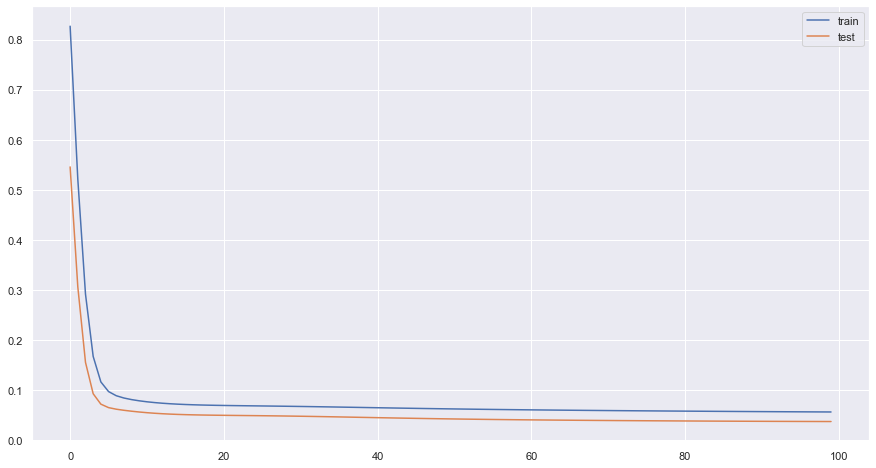

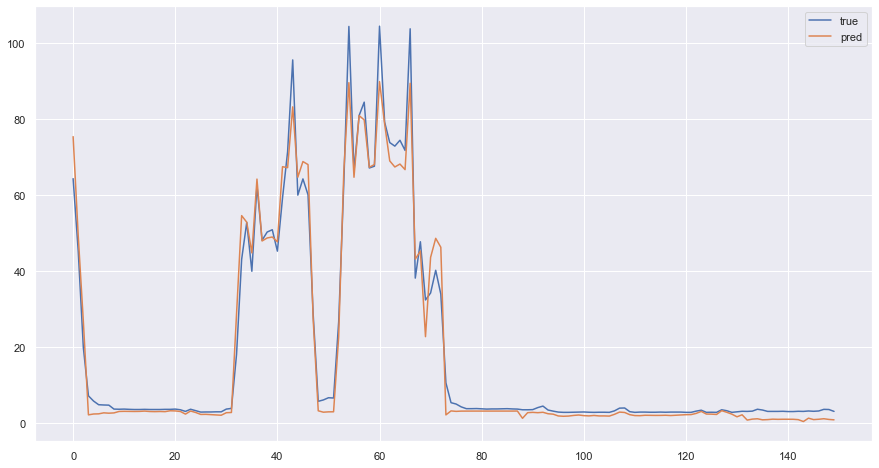

In [9]:
from rnn.rnn import RNN
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x = df.drop(['Usage_kWh'], axis=1).to_numpy()
y = df[["Usage_kWh"]].to_numpy()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)


rnn = RNN(x.shape[1], x.shape[1])
losses = rnn.train(x_train, y_train, x_test, y_test, 100, 0.0001, 3)

def plot_learning_curves(losses: dict[int, list[float]]):
    plt.plot(list(losses.keys()), [loss[0] for loss in losses.values()], label="train")
    plt.plot(list(losses.keys()), [loss[1] for loss in losses.values()], label="test")
    plt.legend()
    plt.show()


plot_learning_curves(losses)
sequence_length = 150
rnn.forward(x_test[:sequence_length])
plt.plot(scaler.inverse_transform(y_test[:sequence_length]), label="true")
plt.plot(scaler.inverse_transform(rnn.output), label="pred")
plt.legend()
plt.show()

In [14]:
def r2_score(y_true, y_pred):
    numerator = np.nansum((y_true - y_pred) ** 2, axis=0, dtype=np.float64)
    denominator = np.nansum((y_true - np.nanmean(y_true, axis=0)) ** 2, axis=0, dtype=np.float64)
    return np.mean(1 - numerator / denominator)

rnn.forward(x_test[:len(x_test)])
r2_score(scaler.inverse_transform(y_test), scaler.inverse_transform(rnn.output))

R2 score: 0.9598121781191467
